In [1]:
# https://medium.com/swlh/predicting-stock-prices-using-deep-learning-models-310b41cec90a
# https://github.com/jbernhard-nw/stock-price-forecasting  

In [12]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from fbprophet import Prophet

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [13]:
def create_files_dict(pth='./data/archive'):
    '''
    create dictionary of files
    '''
    # pull all data files
    files = os.listdir(pth)
    #print(files)

    all_data = dict()
    for file in files:

        # create key and file path
        file_key = file.split('_')[0]
        file_path = os.path.join(pth, file)

        # read the data
        data = pd.read_csv(
            file_path,
            index_col='Date',
            parse_dates=['Date']
        )

        # store data in dictionary
        all_data[file_key] = data

    return all_data


def plot_data(data, stock_name, pth='./figures/'):
    '''
    plot the data
    '''
    # create train and test
    data["High"][:'2016'].plot(figsize=(16, 4), legend=True)
    data["High"]['2017':].plot(figsize=(16, 4), legend=True)

    # plot the data
    plt.legend(['Training set (Before 2017)', 'Test set (2017 and beyond)'])
    plt.title('{} stock price'.format(stock_name))
    fig_path = os.path.join(pth, stock_name + '_train_test')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()


def create_dl_train_test_split(all_data):
    '''
    create training/testing data and scaler object
    '''
    # create training and test set
    training_set = all_data[:'2016'].iloc[:, 1:2].values
    test_set = all_data['2017':].iloc[:, 1:2].values

    # scale the data
    sc = MinMaxScaler(feature_range=(0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # create training and test data
    X_train = []
    y_train = []
    print("Quantity")
    print(len(training_set_scaled))
    for i in range(60, 2768):
        X_train.append(training_set_scaled[i - 60:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping X_train for efficient modelling
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    total_data = pd.concat(
        (all_data["High"][:'2016'], all_data["High"]['2017':]), axis=0)
    inputs = total_data[len(total_data) - len(test_set) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    # Preparing X_test
    X_test = []
    for i in range(60, 311):
        X_test.append(inputs[i - 60:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, sc


def create_single_layer_small_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_single_layer_rnn_model(X_train, y_train, X_test, sc):
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_rnn_model(X_train, y_train, X_test, sc):
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train, epochs=100, batch_size=150)

    # Finalizing predictions
    scaled_preds = model.predict(X_test)
    test_preds = sc.inverse_transform(scaled_preds)

    return model, test_preds


def create_GRU_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dense(units=1))

    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


def create_GRU_with_drop_out_model(X_train, y_train, X_test, sc):
    '''
    create GRU model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # The GRU architecture
    regressorGRU = Sequential()
    # First GRU layer with Dropout regularisation
    regressorGRU.add(GRU(units=50, return_sequences=True,
                         input_shape=(X_train.shape[1], 1), activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Second GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Third GRU layer
    regressorGRU.add(GRU(units=50, return_sequences=True, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # Fourth GRU layer
    regressorGRU.add(GRU(units=50, activation='tanh'))
    regressorGRU.add(Dropout(0.2))
    # The output layer
    regressorGRU.add(Dense(units=1))
    # Compiling the RNN
    regressorGRU.compile(
        optimizer=SGD(
            lr=0.01,
            decay=1e-7,
            momentum=0.9,
            nesterov=False),
        loss='mean_squared_error')
    # Fitting to the training set
    regressorGRU.fit(X_train, y_train, epochs=50, batch_size=150)

    GRU_predicted_stock_price = regressorGRU.predict(X_test)
    GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

    return regressorGRU, GRU_predicted_stock_price


def create_prophet_results(all_data,
                           final_train_idx=2768,
                           pred_periods=250):
    '''
    create prophet model trained on first 2768 rows by
    default and predicts on last 250 rows
    '''
    # Pull train data
    train_data = all_data[:final_train_idx].reset_index()[['Date', 'High']]
    train_data.columns = ['ds', 'y']

    # Create and fit model
    prophet_model = Prophet()
    prophet_model.fit(train_data)

    # Provide predictions
    test_dates = prophet_model.make_future_dataframe(periods=pred_periods)
    forecast_prices = prophet_model.predict(test_dates)

    return forecast_prices


def create_prophet_daily_results(data):
    '''
    '''
    test_results = pd.DataFrame()
    for val in range(2768, 3019):

        # format training dataframe
        df = data['High'][:val].reset_index()
        df.columns = ['ds', 'y']

        # Instantiate and fit the model
        proph_model = Prophet(daily_seasonality=True)
        proph_model.fit(df)

        # create test dataframe
        test_dates = proph_model.make_future_dataframe(periods=1)

        # store test results in dataframe
        preds = proph_model.predict(test_dates).tail(1)
        test_results = test_results.append(preds)

    return test_results


def plot_results(actuals,
                 stock_name,
                 small_one_layer_preds,
                 one_layer_preds,
                 yearly_prophet_preds,
                 gru_drop_preds,
                 rnn_preds,
                 gru_preds,
                 plot_pth='./figures'):
    '''
    plot the results
    '''
    plt.figure(figsize=(20, 5))
    plt.plot(yearly_prophet_preds.reset_index()[
             'yhat'].values[-250:], label='prophet yearly predictions')
    plt.plot(stock_data["High"]['2017':].values[:-1], label='actual values')
    plt.plot(small_one_layer_preds, label='Single Layer Small RNN values')
    plt.plot(one_layer_preds, label='Single Layer RNN values')
    plt.plot(gru_drop_preds, label='GRU with dropout values')
    plt.plot(rnn_preds, label='RNN values')
    plt.plot(gru_preds, label='GRU values')
    plt.title('{} Predictions from Prophet vs. Actual'.format(stock_name))
    plt.legend()

    fig_path = os.path.join(plot_pth, 'results', stock_name + '_preds')

    # save the data, pause, and close
    plt.savefig(fig_path)
    plt.pause(1)
    plt.close()

In [14]:
all_data = create_files_dict()

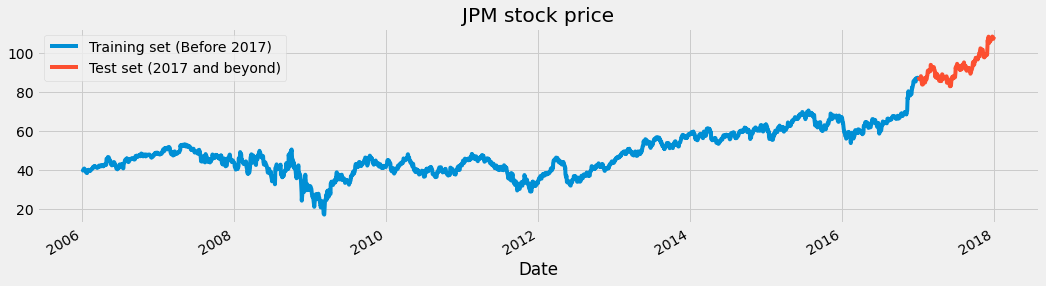

Quantity
2769
Train on 2708 samples
Epoch 1/100
2708/2708 [==============================] - 0s 51us/sample - loss: 0.1162
Epoch 2/100
2708/2708 [==============================] - 0s 56us/sample - loss: 0.0599
Epoch 3/100
2708/2708 [==============================] - 0s 39us/sample - loss: 0.0450
Epoch 4/100
2708/2708 [==============================] - 0s 48us/sample - loss: 0.0246
Epoch 5/100
2708/2708 [==============================] - 0s 46us/sample - loss: 0.0123
Epoch 6/100
2708/2708 [==============================] - 0s 42us/sample - loss: 0.0083
Epoch 7/100
2708/2708 [==============================] - 0s 44us/sample - loss: 0.0065
Epoch 8/100
2708/2708 [==============================] - 0s 57us/sample - loss: 0.0053
Epoch 9/100
2708/2708 [==============================] - 0s 50us/sample - loss: 0.0047
Epoch 10/100
2708/2708 [==============================] - 0s 52us/sample - loss: 0.0043
Epoch 11/100
2708/2708 [==============================] - 0s 65us/sample - loss: 0.0040
Epoch

2708/2708 [==============================] - 0s 63us/sample - loss: 7.6977e-04
Epoch 93/100
2708/2708 [==============================] - 0s 51us/sample - loss: 7.4522e-04
Epoch 94/100
2708/2708 [==============================] - 0s 48us/sample - loss: 7.8504e-04
Epoch 95/100
2708/2708 [==============================] - 0s 49us/sample - loss: 6.9871e-04
Epoch 96/100
2708/2708 [==============================] - 0s 49us/sample - loss: 7.5499e-04
Epoch 97/100
2708/2708 [==============================] - 0s 52us/sample - loss: 6.7251e-04
Epoch 98/100
2708/2708 [==============================] - 0s 53us/sample - loss: 7.9245e-04
Epoch 99/100
2708/2708 [==============================] - 0s 53us/sample - loss: 7.8158e-04
Epoch 100/100
2708/2708 [==============================] - 0s 54us/sample - loss: 7.7213e-04


W1004 02:00:12.313291 139905509537600 deprecation.py:323] From /home/caiquecoelho/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Train on 2708 samples
Epoch 1/100
2708/2708 [==============================] - 0s 50us/sample - loss: 0.0230
Epoch 2/100
2708/2708 [==============================] - 0s 49us/sample - loss: 0.0051
Epoch 3/100
2708/2708 [==============================] - 0s 48us/sample - loss: 0.0032
Epoch 4/100
2708/2708 [==============================] - 0s 51us/sample - loss: 0.0027
Epoch 5/100
2708/2708 [==============================] - 0s 50us/sample - loss: 0.0022
Epoch 6/100
2708/2708 [==============================] - 0s 70us/sample - loss: 0.0025
Epoch 7/100
2708/2708 [==============================] - 0s 57us/sample - loss: 0.0016
Epoch 8/100
2708/2708 [==============================] - 0s 67us/sample - loss: 0.0016
Epoch 9/100
2708/2708 [==============================] - 0s 62us/sample - loss: 0.0014
Epoch 10/100
2708/2708 [==============================] - 0s 69us/sample - loss: 0.0013
Epoch 11/100
2708/2708 [==============================] - 0s 61us/sample - loss: 0.0011
Epoch 12/100
2708/2

2708/2708 [==============================] - 0s 56us/sample - loss: 1.9334e-04
Epoch 91/100
2708/2708 [==============================] - 0s 58us/sample - loss: 1.7661e-04
Epoch 92/100
2708/2708 [==============================] - 0s 57us/sample - loss: 1.9803e-04
Epoch 93/100
2708/2708 [==============================] - 0s 56us/sample - loss: 1.6870e-04
Epoch 94/100
2708/2708 [==============================] - 0s 55us/sample - loss: 1.7942e-04
Epoch 95/100
2708/2708 [==============================] - 0s 59us/sample - loss: 1.9050e-04
Epoch 96/100
2708/2708 [==============================] - 0s 58us/sample - loss: 1.7727e-04
Epoch 97/100
2708/2708 [==============================] - 0s 57us/sample - loss: 1.7743e-04
Epoch 98/100
2708/2708 [==============================] - 0s 55us/sample - loss: 1.7164e-04
Epoch 99/100
2708/2708 [==============================] - 0s 56us/sample - loss: 1.8922e-04
Epoch 100/100
2708/2708 [==============================] - 0s 59us/sample - loss: 1.8457e-04


2708/2708 [==============================] - 1s 253us/sample - loss: 0.0016
Epoch 82/100
2708/2708 [==============================] - 1s 224us/sample - loss: 0.0016
Epoch 83/100
2708/2708 [==============================] - 1s 225us/sample - loss: 0.0016
Epoch 84/100
2708/2708 [==============================] - 1s 225us/sample - loss: 9.1273e-04
Epoch 85/100
2708/2708 [==============================] - 1s 222us/sample - loss: 0.0020
Epoch 86/100
2708/2708 [==============================] - 1s 220us/sample - loss: 0.0015
Epoch 87/100
2708/2708 [==============================] - 1s 225us/sample - loss: 0.0017
Epoch 88/100
2708/2708 [==============================] - 1s 222us/sample - loss: 0.0014
Epoch 89/100
2708/2708 [==============================] - 1s 222us/sample - loss: 0.0017
Epoch 90/100
2708/2708 [==============================] - 1s 223us/sample - loss: 0.0013
Epoch 91/100
2708/2708 [==============================] - 1s 225us/sample - loss: 0.0015
Epoch 92/100
2708/2708 [======

KeyboardInterrupt: 

In [15]:
for stock_name, stock_data in all_data.items():
    # initial plots
    plot_data(stock_data, stock_name)

    # create dl data
    X_train, y_train, X_test, sc = create_dl_train_test_split(stock_data)

    # create small single layer small rnn preds
    small_single_layer_rnn, small_one_layer_preds = create_single_layer_small_rnn_model(
        X_train, y_train, X_test, sc)

    # create single layer rnn preds
    single_layer_rnn, one_layer_preds = create_single_layer_rnn_model(
        X_train, y_train, X_test, sc)

    # rnn daily preds
    rnn_model, rnn_preds = create_rnn_model(X_train, y_train, X_test, sc)

    # gru daily preds
    gru_model, gru_preds = create_GRU_model(X_train, y_train, X_test, sc)

    # gru daily preds
    gru_drop_model, gru_drop_preds = create_GRU_with_drop_out_model(
        X_train, y_train, X_test, sc)

    # yearly preds
    yearly_preds = create_prophet_results(stock_data)

    # daily preds
    # prophet_daily_preds = create_prophet_daily_results(stock_data)

    # plot results
    plot_results(stock_data,
                 stock_name,
                 small_one_layer_preds,
                 one_layer_preds,
                 yearly_preds,
                 gru_drop_preds,
                 rnn_preds,
                 gru_preds)